In [1]:
# Run 'source ~/.profile'
import satpy
from satpy import Scene, find_files_and_readers
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyresample import geometry
from pyproj import CRS
from satpy.composites import GenericCompositor
from satpy.writers import to_image
import os

sys.path.insert(0,'/home/cameron/Projects/')

files_1 = find_files_and_readers(base_dir="/home/cameron/Dropbox/Data/20220827_CaptureDL_00_erie_2022_08_27T16_05_36/", reader='hypso1_bip')
files_2 = find_files_and_readers(base_dir="/home/cameron/Nedlastinger/20230519_CaptureDL_erie_2023-05-17_1553Z/", reader='hypso1_bip')

scene_1 = Scene(filenames=files_1, reader_kwargs={'flip': True})
scene_2 = Scene(filenames=files_2)

datasets_1 = scene_1.available_dataset_names()
datasets_2 = scene_2.available_dataset_names()

#scene_1.load(datasets_1)
#scene_2.load(datasets_2)

scene_1.load(['latitude', 'longitude', '80', '40', '15'])
scene_2.load(['latitude', 'longitude', '80', '40', '15'])


grid_lats = scene_1['80'].attrs['area'].lats.data
grid_lons = scene_1['80'].attrs['area'].lons.data

lon_min = grid_lons.min()
lon_max = grid_lons.max()
lat_min = grid_lats.min()
lat_max = grid_lats.max()

bbox = (lon_min,lat_min,lon_max,lat_max)

print(bbox)

area_id = 'western_lake_erie'
proj_id = 'roi'
description = 'roi'
projection = CRS.from_epsg(4326)
width = 600
height = 1800
area_extent = list(bbox)

# Define area definition
area_def = geometry.AreaDefinition(area_id, proj_id, description, projection,  width, height, area_extent)

# Writing Area Definitions: https://pyresample.readthedocs.io/en/stable/howtos/geometry_utils.html#writing-to-disk
filename = os.path.join('.', 'areas', area_id + '.yaml')
with open(filename, 'w') as file:
    file.write(area_def.dump())

# Reading Area Definitions: https://satpy.readthedocs.io/en/stable/resample.html#store-area-definitions
#from pyresample import load_area
#area_def_loaded = load_area(filename)

# Resample to area_def
local_scene_1 = scene_1.resample(area_def, resampler='bilinear', fill_value=np.NaN)
local_scene_2 = scene_2.resample(area_def, resampler='bilinear', fill_value=np.NaN)



gamma = 2

# Original capture composites

s = scene_1
compositor = GenericCompositor("overview")
composite = compositor([s['80'][:,::3], s['40'][:,::3], s['15'][:,::3]]) # Red, Green, Blue
#composite = composite[:,:,::-1] # correct for composite mirroring
img = to_image(composite[:,:,::-1]) 
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene1.png')

s = scene_2
compositor = GenericCompositor("overview")
composite = compositor([s['80'][:,::3], s['40'][:,::3], s['15'][:,::3]]) # Red, Green, Blue
#composite = composite[:,:,::-1] # correct for composite mirroring
img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene2.png')


# Resampled capture composites

s = local_scene_1
compositor = GenericCompositor("overview")
composite = compositor([s['80'], s['40'], s['15']]) # Red, Green, Blue
img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene1_resampled.png')

s = local_scene_2
compositor = GenericCompositor("overview")
composite = compositor([s['80'], s['40'], s['15']]) # Red, Green, Blue
img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene2_resampled.png')






[INFO] Flipping capture /home/cameron/Dropbox/Data/20220827_CaptureDL_00_erie_2022_08_27T16_05_36/erie_2022_08_27T16_05_36.bip in the cross track dimension.
[INFO] Flipping capture /home/cameron/Dropbox/Data/20220827_CaptureDL_00_erie_2022_08_27T16_05_36/erie_2022_08_27T16_05_36-bin3.points in the cross track dimension.
(-83.67992487916133, 41.498003649245746, -82.14908531559405, 44.27169035658254)


/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.ast

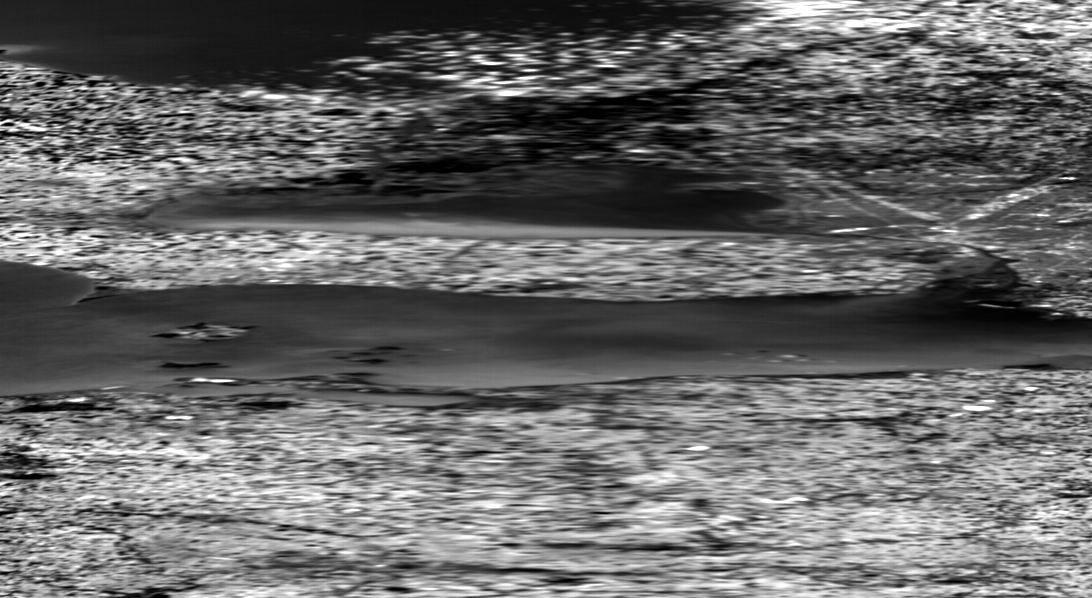

In [5]:
scene_2.show('80')

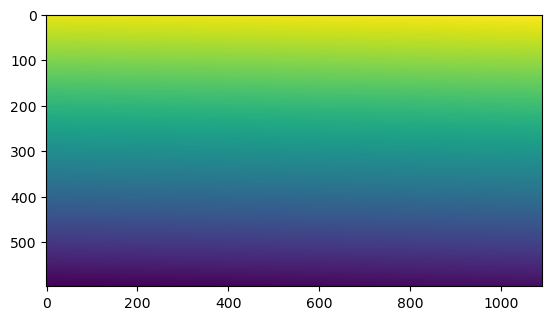

In [9]:
plt.imshow(scene_2['latitude'])